<a href="https://colab.research.google.com/github/mafiTec/Natural-Language-Processing/blob/main/Collaborative_Filtering_Using_k_Nearest_Neighbors_(KNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative Filtering Using k-Nearest Neighbors (KNN)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
users = pd.read_csv('/content/drive/MyDrive/Step 4-3 NLP03_Recommendation System/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
print("Dimension of users dataset:",users.shape)
users.head()

Dimension of users dataset: (278858, 3)


,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
books = pd.read_csv('/content/drive/MyDrive/Step 4-3 NLP03_Recommendation System/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
print("Dimension of books dataset:",books.shape)
books.head()

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


Dimension of books dataset: (271360, 8)


,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
ratings = pd.read_csv('/content/drive/MyDrive/Step 4-3 NLP03_Recommendation System/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']
print("Dimension of ratings dataset:", ratings.shape)
ratings.head()

Dimension of ratings dataset: (1149780, 3)


,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: bookRating, dtype: int64
**************************************************


Text(0.5, 1.0, 'Score distribution')

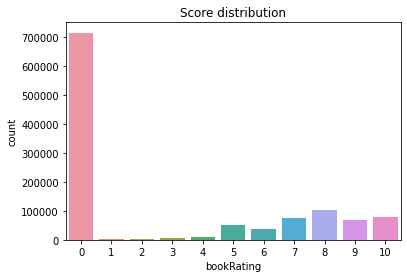

In [7]:
#data points for each Rating
print(ratings['bookRating'].value_counts(sort=False))
print("*"*50)

#Count plot for Rating
sns.countplot('bookRating',data = ratings)
plt.title("Score distribution")

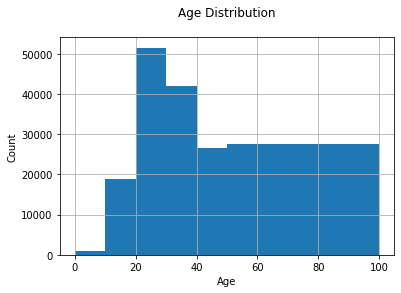

In [8]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Excluding users with less than 200 ratings and books with less than 100 ratings

In [9]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]

counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

print("Updated Dimension of ratings dataset:",ratings.shape)

Updated Dimension of ratings dataset: (527556, 3)



Merging rating and book datasets

In [10]:
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...


Groupby book titles and create a new column for total rating count

In [11]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])

book_ratingCount = (combine_book_rating.groupby(by = ['bookTitle'])['bookRating'].count().reset_index().
                     rename(columns = {'bookRating': 'totalRatingCount'})[['bookTitle', 'totalRatingCount']])

book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


Merging combine_book_rating with the book_ratingCount, this gives us exactly what we need to find out which books are popular and filter out lesser-known books

In [12]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'bookTitle',
                                                                 right_on = 'bookTitle', how = 'left')

rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


In [13]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
print("rating_popular_book shape:",rating_popular_book.shape)
rating_popular_book.head()

rating_popular_book shape: (62149, 5)


,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82



Merging rating_popular_book and users dataset

In [14]:
combined = rating_popular_book.merge(users, left_on = 'userID', right_on = 'userID', how = 'left')
print(combined.shape)
combined.head()

(62149, 7)


,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location,Age
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"gilbert, arizona, usa",48.0
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"knoxville, tennessee, usa",29.0
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82,"n/a, n/a, n/a",NaN
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"byron, minnesota, usa",18.0
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"cordova, tennessee, usa",32.0


In [15]:

combined.isna().sum()

userID                  0
ISBN                    0
bookRating              0
bookTitle               0
totalRatingCount        0
Location                0
Age                 14004
dtype: int64

Filter to users in US and Canada only

In [16]:
us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating = us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"gilbert, arizona, usa"
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"knoxville, tennessee, usa"
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"byron, minnesota, usa"
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"cordova, tennessee, usa"
5,16795,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"mechanicsville, maryland, usa"


Implementing kNN
We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors). We then transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.

Finding the Nearest Neighbors We use unsupervised algorithms with sklearn.neighbors. The algorithm we use to compute the nearest neighbors is “brute”, and we specify “metric=cosine” so that the algorithm will calculate the cosine similarity between rating vectors. Finally, we fit the model.

In [17]:
from scipy.sparse import csr_matrix
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
us_canada_user_rating_pivot.head()

userID,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,6543,6563,6575,7158,7286,7346,7915,8067,8245,8681,8936,9856,10447,10819,11601,11993,12538,12824,13082,13273,13552,13850,14422,14521,15408,16106,16634,16795,16916,16966,...,260897,261829,262399,263163,263460,263877,264031,264082,264321,264637,265115,265313,265889,266056,266226,266753,266865,267635,268032,268110,268330,268622,268932,269566,269719,269890,270713,270820,271195,271284,271448,271705,273979,274061,274308,274808,275970,277427,277639,278418
bookTitle,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0


transforming values(ratings) of the matrix dataframe into a scipy sparse matrix

In [18]:
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)
us_canada_user_rating_matrix

<746x734 sparse matrix of type '<class 'numpy.float64'>'
	with 13028 stored elements in Compressed Sparse Row format>

In [19]:
from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [20]:
query_index = 116
print(us_canada_user_rating_pivot.index[query_index])

distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
print("distance:",distances, "\nindices:", indices)

Chromosome 6
distance: [[2.22044605e-16 3.63639858e-01 6.82911738e-01 6.92616434e-01
  7.12197510e-01 7.30848054e-01]] 
indices: [[116  36 592 702 128 283]]


In [21]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Chromosome 6:

1: Acceptable Risk, with distance of 0.3636398583669789:
2: The Killing Game: Only One Can Win...and the Loser Dies, with distance of 0.6829117384505824:
3: Vector, with distance of 0.6926164340829276:
4: Contagion, with distance of 0.7121975101304703:
5: Invasion, with distance of 0.7308480536731475:
